Data=[19.0, 5.7, 3.8, 1.7], predicted:20, Tag:18
Data=[137.0, 6.3, 3.4, 5.6], predicted:11, Tag:21
Data=[119.0, 7.7, 2.6, 6.9], predicted:2, Tag:11
Data=[25.0, 4.8, 3.4, 1.9], predicted:20, Tag:0
Data=[22.0, 5.1, 3.7, 1.5], predicted:17, Tag:20
Data=[49.0, 5.3, 3.7, 1.5], predicted:20, Tag:0
Data=[134.0, 6.3, 2.8, 5.1], predicted:3, Tag:5
Data=[111.0, 6.5, 3.2, 5.1], predicted:3, Tag:9
Data=[3.0, 4.7, 3.2, 1.3], predicted:0, Tag:0
Data=[89.0, 5.6, 3.0, 4.1], predicted:6, Tag:19
Data=[121.0, 6.9, 3.2, 5.7], predicted:10, Tag:11
Data=[56.0, 5.7, 2.8, 4.5], predicted:5, Tag:19
Data=[108.0, 7.3, 2.9, 6.3], predicted:10, Tag:3
Data=[14.0, 4.3, 3.0, 1.1], predicted:0, Tag:17
Data=[79.0, 6.0, 2.9, 4.5], predicted:6, Tag:5
Data=[63.0, 6.0, 2.2, 4.0], predicted:19, Tag:1
Data=[17.0, 5.4, 3.9, 1.3], predicted:0, Tag:20
Data=[58.0, 4.9, 2.4, 3.3], predicted:1, Tag:1
Data=[115.0, 5.8, 2.8, 5.1], predicted:7, Tag:21
Data=[35.0, 4.9, 3.1, 1.5], predicted:17, Tag:17
Data=[130.0, 7.2, 3.0, 5.8], predi

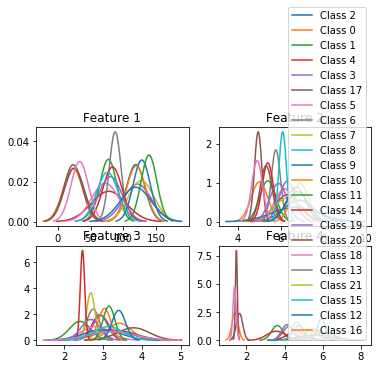

In [5]:
import random
from math import sqrt, exp, pi
import pandas as pd
from colorama import Fore
import matplotlib.pyplot as plt
import numpy as np

def load_csv(filename):
    dataset = []
    dataframe = pd.read_csv(filename)
    for row in dataframe.values.tolist():
        if not row:
            continue
        vector = [float(x) for x in row[:4]]
        vector.append(row[4])
        dataset.append(vector)
    random.shuffle(dataset)
    return dataset

def tagtoint(dataset, column):
    classval = [row[column] for row in dataset]
    unique = set(classval)
    lookup = {}
    for i, val in enumerate(unique):
        lookup[val] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

def separatebyclass(dataset):
    separated = {}
    for vector in dataset:
        tagg = vector[-1]
        if tagg not in separated:
            separated[tagg] = []
        separated[tagg].append(vector[:-1])
    return separated

def mean(numbers):
    return sum(numbers) / float(len(numbers))

def standarddeviation(numbers):
    if len(numbers) < 2:
        return 0  # or handle the special case accordingly
    avg = mean(numbers)
    variance = sum([(x - avg) ** 2 for x in numbers]) / float(len(numbers) - 1)
    return sqrt(variance)


def trainmodel(dataset):
    separated = separatebyclass(dataset)
    model = {}
    for tagg, vectors in separated.items():
        model[tagg] = []
        for i in range(len(vectors[0])):
            mean_val = mean([vector[i] for vector in vectors])
            std_dev = standarddeviation([vector[i] for vector in vectors])
            model[tagg].append((mean_val, std_dev))
    return model

def normaldistribution(x, mean, stdev):
    if abs(stdev) < 1e-9:  # Add a small tolerance value for stdev close to zero
        return np.zeros_like(x)  # or handle the special case accordingly
    exponent = np.exp(-((x - mean) ** 2) / (2 * stdev ** 2))
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent



def predict(model, row):
    probabilities = {}
    for tagg, features in model.items():
        probabilities[tagg] = 1
        for i in range(len(features)):
            mean_val, stdev = features[i]
            probabilities[tagg] *= normaldistribution(row[i], mean_val, stdev)
    bestlabel, bestprob = None, -1
    for tagg, probability in probabilities.items():
        if bestlabel is None or probability > bestprob:
            bestprob = probability
            bestlabel = tagg
    return bestlabel

def plot(model):
    figure, axis = plt.subplots(2, 2)
    for i in range(4):
        for tagg, values in model.items():
            mean_val, stdev = values[i]
            x = np.linspace(mean_val - 3 * stdev, mean_val + 3 * stdev, 100)
            y = normaldistribution(x, mean_val, stdev)
            axis[int(i / 2), i % 2].plot(x, y, label=f'Class {tagg}')
            axis[int(i / 2), i % 2].set_title(f'Feature {i + 1}')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    filename = "iris.csv"
    dataset = load_csv(filename)
    tagtoint(dataset, len(dataset[0]) - 1)
    traindataset = dataset[:120]
    model = trainmodel(traindataset)
    testdataset = dataset[120:]
    error = 0
    for row in testdataset:
        test = row[:-1]
        label = predict(model, test)
        if label == row[-1]:
            print(Fore.GREEN + f'Data={test}, predicted:{label}, Tag:{row[-1]}')
        else:
            print(Fore.RED + f'Data={test}, predicted:{label}, Tag:{row[-1]}')
            error += 1
    print(Fore.YELLOW + f'Prediction Accuracy={(len(testdataset) - error) / len(testdataset) * 100}%')
    plot(model)
